'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer


/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = network(input_ids,audio)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    print("Weighted Accuracy: ", wa)
    print("Unweighted Accuracy: ", ua)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

    ax = plt.subplots(figsize=(8, 5.5))[1]
    sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
    ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
    ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    plt.tight_layout()
    plt.savefig(opt.name + '.png', format='png', dpi=1200)
    plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:39<00:00, 23.54it/s]


0.8102893890675241
Weighted Accuracy:  0.8189871056792372
Unweighted Accuracy:  0.8102893890675241
[[156   6   1  14]
 [ 14 240   5  22]
 [  6   7 175  16]
 [ 19  40  27 185]]


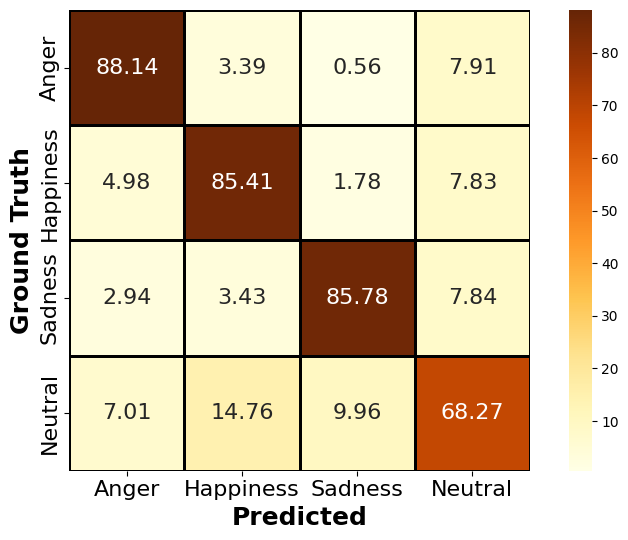

In [3]:
from configs.bert_hubert import Config as bert_hubert_config
opt = bert_hubert_config()
checkpoint_path = "checkpoints/3m-ser_hubert_bert/20230715-093928/weights/best_acc/checkpoint_0.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:38<00:00, 24.52it/s]


0.6152197213290461
Weighted Accuracy:  0.6209301440009003
Unweighted Accuracy:  0.6152197213290461
[[139  11   0  27]
 [ 36 139   9  97]
 [ 11  15  92  86]
 [ 21  31  15 204]]


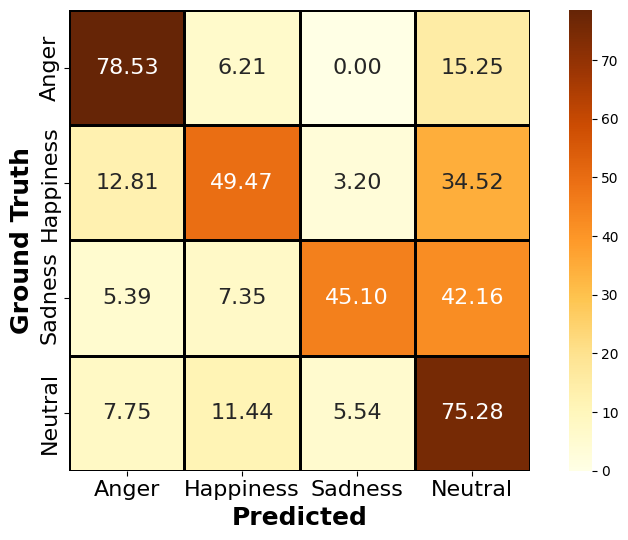

In [4]:
from configs.roberta_hubert import Config as roberta_hubert_config
opt = roberta_hubert_config()
checkpoint_path = "checkpoints/3m-ser_hubert_roberta/20230715-102709/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:29<00:00, 31.80it/s]


0.6216505894962486
Weighted Accuracy:  0.6359266471616828
Unweighted Accuracy:  0.6216505894962486
[[127  22  18  10]
 [ 27 207  28  19]
 [ 11  35 150   8]
 [ 40  69  66  96]]


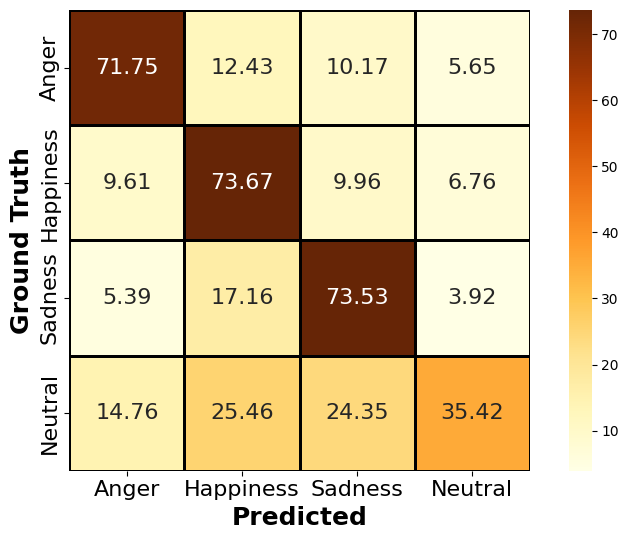

In [5]:
from configs.bert_panns import Config as bert_panns_config
opt = bert_panns_config()
checkpoint_path = "checkpoints/3m-ser_panns_bert/20230716-073642/weights/best_acc/checkpoint_0.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:21<00:00, 44.00it/s]


0.36441586280814575
Weighted Accuracy:  0.3591794595050757
Unweighted Accuracy:  0.36441586280814575
[[ 63  50  22  42]
 [ 36  61  48 136]
 [  5  27  55 117]
 [  8  57  45 161]]


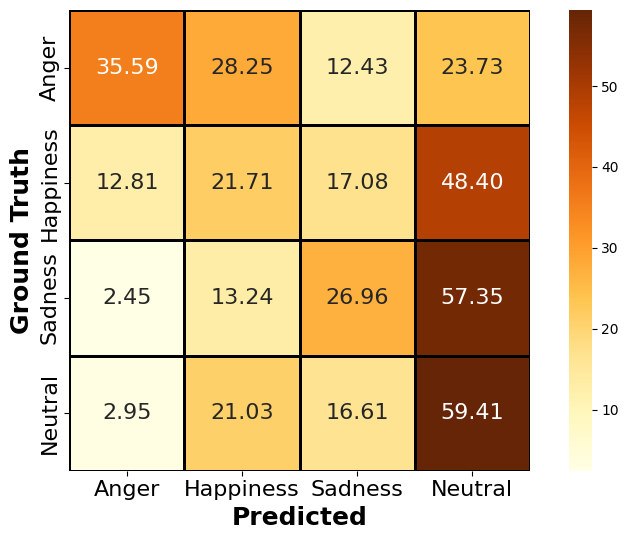

In [13]:
from configs.roberta_panns import Config as roberta_panns_config
opt = roberta_panns_config()
checkpoint_path = "checkpoints/3m-ser_panns_roberta/20230716-073517/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:22<00:00, 42.34it/s]


0.7920685959271169
Weighted Accuracy:  0.8043495093067329
Unweighted Accuracy:  0.7920685959271169
[[153   8   3  13]
 [ 10 228  10  33]
 [  6   6 182  10]
 [ 18  43  34 176]]


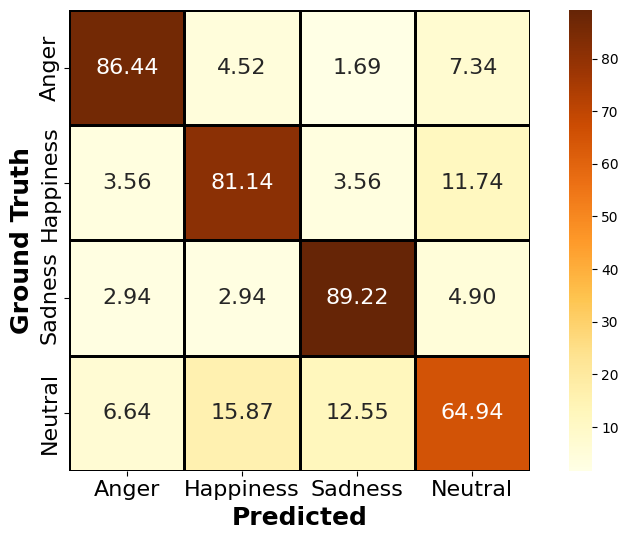

In [7]:
from configs.bert_vggish import Config as bert_vggish_config
opt = bert_vggish_config()
checkpoint_path = "checkpoints/3m-ser_vggish_bert/20230714-232118/weights/best_acc/checkpoint_0.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:21<00:00, 43.00it/s]


0.4180064308681672
Weighted Accuracy:  0.4150059585287508
Unweighted Accuracy:  0.4180064308681672
[[ 94  26   1  56]
 [ 78  62   7 134]
 [ 15  15  37 137]
 [ 34  27  13 197]]


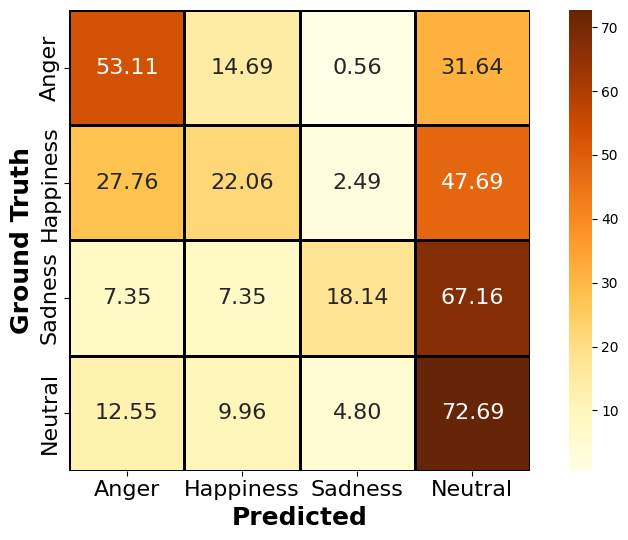

In [8]:
from configs.roberta_vggish import Config as roberta_vggish_config
opt = roberta_vggish_config()
checkpoint_path = "checkpoints/3m-ser_vggish_roberta/20230715-102458/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:31<00:00, 29.68it/s]


0.8060021436227224
Weighted Accuracy:  0.8145007674162491
Unweighted Accuracy:  0.8060021436227224
[[146  10   3  18]
 [ 12 235  11  23]
 [  3   2 188  11]
 [ 20  31  37 183]]


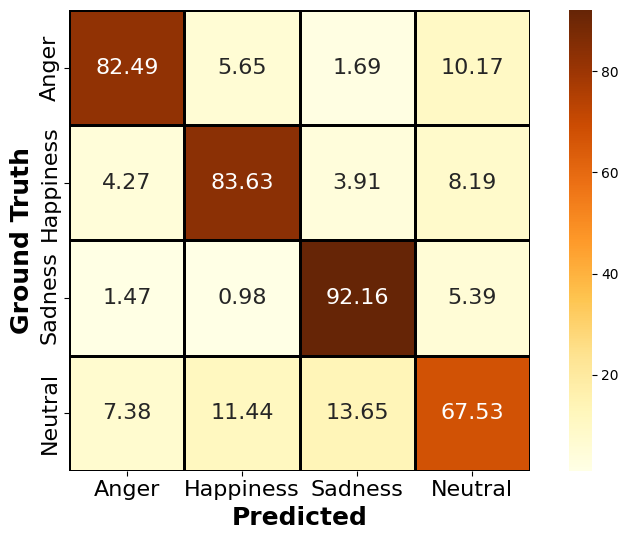

In [9]:
from configs.bert_wav2vec2 import Config as bert_wav2vec2_config
opt = bert_wav2vec2_config()
checkpoint_path = "checkpoints/3m-ser_wav2vec2_bert/20230714-132857/weights/best_acc/checkpoint_0.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:38<00:00, 24.42it/s]


0.5273311897106109
Weighted Accuracy:  0.5324648960238036
Unweighted Accuracy:  0.5273311897106109
[[103  13   5  56]
 [ 54 103  17 107]
 [  5  14 104  81]
 [ 22  39  28 182]]


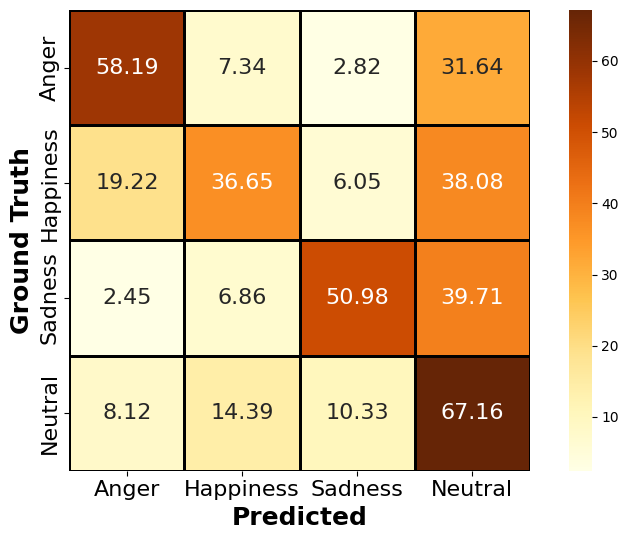

In [10]:
from configs.roberta_wav2vec2 import Config as roberta_wav2vec2_config
opt = roberta_wav2vec2_config()
checkpoint_path = "checkpoints/3m-ser_wav2vec2_roberta/20230715-102745/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:38<00:00, 24.13it/s]


0.7802786709539121
Weighted Accuracy:  0.7906915314864413
Unweighted Accuracy:  0.7802786709539121
[[145   9   6  17]
 [  8 234  12  27]
 [  3   6 184  11]
 [ 20  44  42 165]]


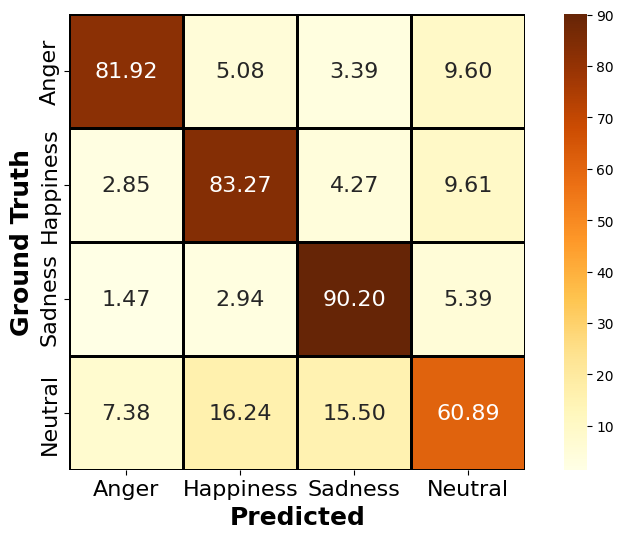

In [11]:
from configs.bert_wavlm import Config as bert_wavlm_config
opt = bert_wavlm_config()
checkpoint_path = "checkpoints/3m-ser_wavlm_bert/20230714-133030/weights/best_acc/checkpoint_0.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:40<00:00, 23.21it/s]


0.5884244372990354
Weighted Accuracy:  0.5957812142226261
Unweighted Accuracy:  0.5884244372990354
[[132  15   0  30]
 [ 40 135  10  96]
 [  9  14  96  85]
 [ 25  43  17 186]]


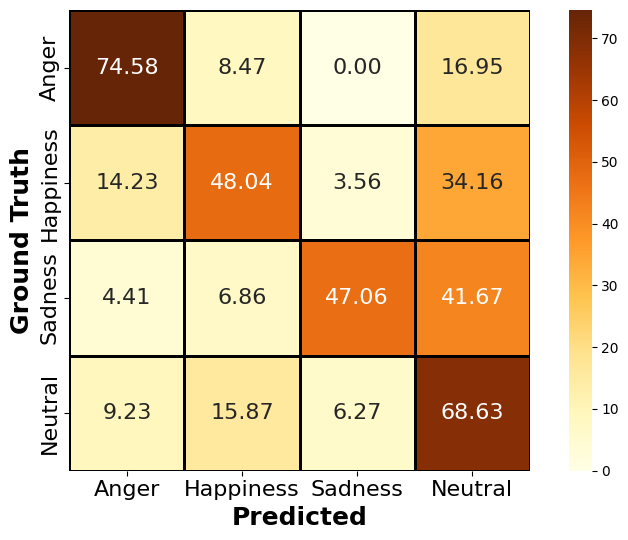

In [12]:
from configs.roberta_wavlm import Config as roberta_wavlm_config
opt = roberta_wavlm_config()
checkpoint_path = "checkpoints/3m-ser_wavlm_roberta/20230715-102824/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 708/708 [02:55<00:00,  4.04it/s]


0.8036723163841808
Weighted Accuracy:  0.8036723163841808
Unweighted Accuracy:  0.8036723163841808
[[160   2   5  10]
 [ 11 137   9  20]
 [  4   6 157  10]
 [ 14  29  19 115]]


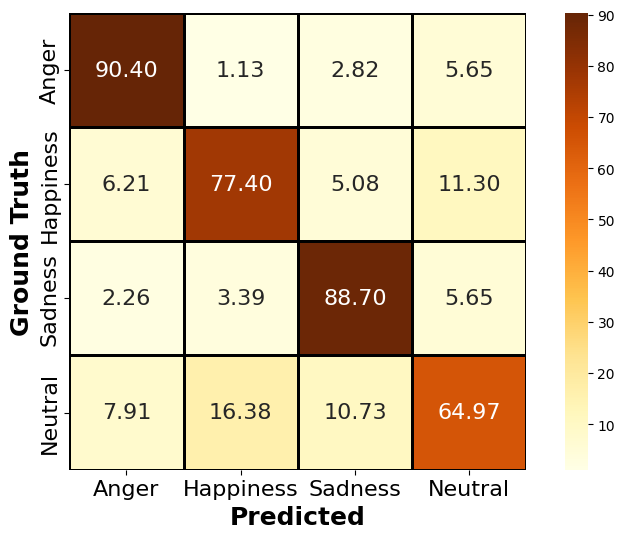

In [3]:
from configs.roberta_wav2vec2_balance import Config as roberta_wav2vec2_balance
opt = roberta_wav2vec2_balance()
checkpoint_path = "checkpoints/roberta_wav2vec2_balance/20230720-105727/weights/best_acc/checkpoint_0.pt"
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
eval(opt, checkpoint_path, tokenizer)